### Construcción de una red basada en correlaciones entre programas presidenciales

#### Librerías

In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
from networkx.algorithms import community
import community as community_louvain
from IPython.display import Markdown, display
import glob
from PIL import Image

In [30]:
# cargar Analytical_Data
df_AD = pd.read_excel('data/Analytical_Data.xlsx')
df_AD.head()


,Dominio,Nombre_Dominio,Variable_per,Detalle_Dominio
0,Domain_1,External Relations,per101,Foreign Special Relationships: Positive
1,Domain_1,External Relations,per102,Foreign Special Relationships: Negative
2,Domain_1,External Relations,per103,Anti-Imperialism
3,Domain_1,External Relations,per104,Military: Positive
4,Domain_1,External Relations,per105,Military: Negative


In [31]:
# cargar períodos
df_ventana_10 = pd.read_excel('data/Ventana_10.xlsx')
df_ventana_5 = pd.read_excel('data/Ventana_5.xlsx')

In [32]:
df_ventana_5

,agno,ventana
0,1920,1
1,1921,1
2,1922,1
3,1923,1
4,1924,1
...,...,...
99,2019,20
100,2020,21
101,2021,21
102,2022,21


#### Cargamos desde el excel

In [33]:
# Cargar el dataframe desde un archivo Excel
correlation_matrix = pd.read_excel('correlation_matrix.xlsx', index_col=0)  # 'index_col=0' para cargar la columna de índice correctamente


In [34]:
correlation_matrix

,Albania_15,Albania_16,Albania_17,Argentina_14,Argentina_16,Argentina_17,Argentina_18,Argentina_19,Argentina_20,Armenia_16,...,Uruguay_11,Uruguay_12,Uruguay_13,Uruguay_14,Uruguay_15,Uruguay_16,Uruguay_17,Uruguay_18,Uruguay_20,Uruguay_21
pair,,,,,,,,,,,,,,,,,,,,,
Albania_15,1.000000,0.000000,0.000000,0.553442,0.575908,0.554576,0.527684,0.519215,0.540114,0.803857,...,0,0,0,0,0,0,0,0,0,0
Albania_16,0.000000,1.000000,0.000000,0.468196,0.507012,0.487507,0.495225,0.426757,0.457873,0.705638,...,0,0,0,0,0,0,0,0,0,0
Albania_17,0.000000,0.000000,1.000000,0.471237,0.526964,0.522082,0.511389,0.430358,0.478863,0.711718,...,0,0,0,0,0,0,0,0,0,0
Argentina_14,0.553442,0.468196,0.471237,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.604121,...,0,0,0,0,0,0,0,0,0,0
Argentina_16,0.575908,0.507012,0.526964,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.627385,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Uruguay_16,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,1,0,0,0,0
Uruguay_17,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,1,0,0,0
Uruguay_18,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,1,0,0


#### VERIFIQUEMOS LA SANIDAD DE LA MATRIZ DE CORRELACIONES

##### Veamos si hay valores nulos en la matriz

In [35]:
# Verificar si hay valores nulos en la matriz de correlaciones
if correlation_matrix.isnull().values.any():
    print("Hay valores nulos en la matriz de correlaciones. Revisa los datos.")
else:
    print("No hay valores nulos en la matriz de correlaciones.")


No hay valores nulos en la matriz de correlaciones.


#### Veamos si la matriz es simétrica

In [36]:
# Verificar si la matriz de correlaciones es simétrica
if (correlation_matrix == correlation_matrix.T).all().all():
    print("La matriz de correlaciones es simétrica.")
else:
    print("La matriz de correlaciones NO es simétrica. Revisa los cálculos.")


La matriz de correlaciones es simétrica.


#### Calculemos el número de correlaciones calculadas (excluyendo la diagonal)

In [37]:
# Número de pares únicos
N = len(correlation_matrix)

# Contar el número de correlaciones distintas de 1.0, excluyendo la diagonal
correlations_calculated = (correlation_matrix != 1).sum().sum() / 2  # Dividir por 2 para evitar dobles conteos

# Número total esperado de correlaciones (excluyendo la diagonal)
expected_correlations = (N * (N - 1)) / 2

if correlations_calculated == expected_correlations:
    print(f"Se calcularon todas las correlaciones correctamente. Total: {int(correlations_calculated)}")
else:
    print(f"Faltan correlaciones. Calculadas: {int(correlations_calculated)}, Esperadas: {int(expected_correlations)}")


Se calcularon todas las correlaciones correctamente. Total: 989121


#### Imprimamos  una muestra aleatoria de correlaciones

In [58]:
# Mostrar una muestra aleatoria de 5 pares de correlaciones
sample = correlation_matrix.sample(5, axis=0).sample(5, axis=1)
print("Muestra aleatoria de correlaciones:")
print(sample)


Muestra aleatoria de correlaciones:
             Romania_3  Serbia_13  Belgium_13  Poland_16  \
pair                                                       
Bulgaria_5           0          0    0.000000   0.000000   
Norway_20            0          0    0.659466   0.460393   
Slovenia_10          0          0    0.000000   0.000000   
Ukraine_10           0          0    0.000000   0.000000   
Armenia_1            0          0    0.000000   0.000000   

             German Democratic Republic_19  
pair                                        
Bulgaria_5                               0  
Norway_20                                0  
Slovenia_10                              0  
Ukraine_10                               0  
Armenia_1                                0  


#### FILTREMOS LA MATRIZ DE CORRELACIONES A UN PERÍODO

In [39]:
period = 14

In [40]:
def obtener_desde_hasta(df, ventana):
    # Filtrar el DataFrame para la ventana especificada
    df_filtrado = df[df['ventana'] == ventana]
    
    # Obtener los valores mínimo y máximo de 'agno' para esa ventana
    desde = df_filtrado['agno'].min()
    hasta = df_filtrado['agno'].max()
    
    return desde, hasta

desde, hasta = obtener_desde_hasta(df_ventana_5, period)
print(f"Para la ventana {period}, los valores de 'agno' son desde {desde} hasta {hasta}")


Para la ventana 14, los valores de 'agno' son desde 1985 hasta 1989


In [41]:
# Filtrar la matriz de correlaciones para un período específico
def filter_correlation_matrix_by_period(correlation_matrix, period):
    # Crear una lista de pares que corresponden al período seleccionado
    period_pairs = [pair for pair in correlation_matrix.index if pair.endswith(f"_{period}")]
    
    # Filtrar la matriz de correlaciones usando los pares seleccionados
    filtered_matrix = correlation_matrix.loc[period_pairs, period_pairs]
    
    return filtered_matrix

# Filtrar la matriz para el período 15
filtered_correlation_matrix = filter_correlation_matrix_by_period(correlation_matrix, period)


In [42]:
filtered_correlation_matrix

,Argentina_14,Australia_14,Austria_14,Belgium_14,Brazil_14,Canada_14,Chile_14,Denmark_14,Finland_14,France_14,...,Romania_14,Russia_14,Serbia_14,Slovakia_14,Slovenia_14,South Africa_14,South Korea_14,Sri Lanka_14,Ukraine_14,Uruguay_14
pair,,,,,,,,,,,,,,,,,,,,,
Argentina_14,1.000000,0.600136,0.652232,0.660139,0.830947,0.598663,0.786252,0.633214,0.612693,0.621653,...,0,0,0,0,0,0,0,0,0,0
Australia_14,0.600136,1.000000,0.796855,0.804002,0.588502,0.768496,0.678361,0.818109,0.856469,0.836468,...,0,0,0,0,0,0,0,0,0,0
Austria_14,0.652232,0.796855,1.000000,0.885945,0.610934,0.755101,0.674795,0.853290,0.786364,0.879263,...,0,0,0,0,0,0,0,0,0,0
Belgium_14,0.660139,0.804002,0.885945,1.000000,0.616432,0.838152,0.704545,0.896977,0.826349,0.941140,...,0,0,0,0,0,0,0,0,0,0
Brazil_14,0.830947,0.588502,0.610934,0.616432,1.000000,0.565370,0.838642,0.601077,0.625609,0.586382,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
South Africa_14,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,1,0,0,0,0
South Korea_14,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,1,0,0,0
Sri Lanka_14,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,1,0,0


#### THRESHOLD

In [76]:
threshold = 0.8

#### HEATMAP

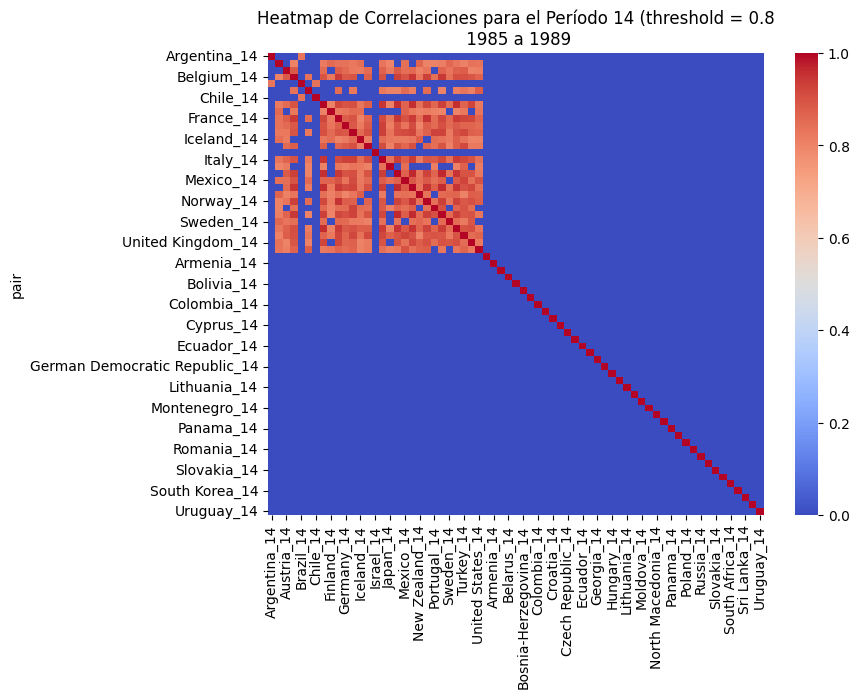

In [77]:
import seaborn as sns
import matplotlib.pyplot as plt

# Función para visualizar el heatmap de la matriz filtrada
def plot_heatmap(filtered_correlation_matrix, threshold):
    # Aplicar el threshold
    filtered_corr = filtered_correlation_matrix[filtered_correlation_matrix >= threshold].fillna(0)
    
    # Plotear el heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(filtered_corr, cmap='coolwarm', annot=False, cbar=True)
    plt.title(f"Heatmap de Correlaciones para el Período {period} (threshold = {threshold}\n {desde} a {hasta}")
    plt.show()

# Usar la función para visualizar el heatmap con un threshold definido
plot_heatmap(filtered_correlation_matrix, threshold)


In [78]:
filtered_correlation_matrix

,Argentina_14,Australia_14,Austria_14,Belgium_14,Brazil_14,Canada_14,Chile_14,Denmark_14,Finland_14,France_14,...,Romania_14,Russia_14,Serbia_14,Slovakia_14,Slovenia_14,South Africa_14,South Korea_14,Sri Lanka_14,Ukraine_14,Uruguay_14
pair,,,,,,,,,,,,,,,,,,,,,
Argentina_14,1.000000,0.600136,0.652232,0.660139,0.830947,0.598663,0.786252,0.633214,0.612693,0.621653,...,0,0,0,0,0,0,0,0,0,0
Australia_14,0.600136,1.000000,0.796855,0.804002,0.588502,0.768496,0.678361,0.818109,0.856469,0.836468,...,0,0,0,0,0,0,0,0,0,0
Austria_14,0.652232,0.796855,1.000000,0.885945,0.610934,0.755101,0.674795,0.853290,0.786364,0.879263,...,0,0,0,0,0,0,0,0,0,0
Belgium_14,0.660139,0.804002,0.885945,1.000000,0.616432,0.838152,0.704545,0.896977,0.826349,0.941140,...,0,0,0,0,0,0,0,0,0,0
Brazil_14,0.830947,0.588502,0.610934,0.616432,1.000000,0.565370,0.838642,0.601077,0.625609,0.586382,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
South Africa_14,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,1,0,0,0,0
South Korea_14,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,1,0,0,0
Sri Lanka_14,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,1,0,0


#### CREAMOS LA RED DE SIMILARIDAD

/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_4954/3135907941.py:38: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(cm.ScalarMappable(norm=norm, cmap='coolwarm'), label="Correlación")


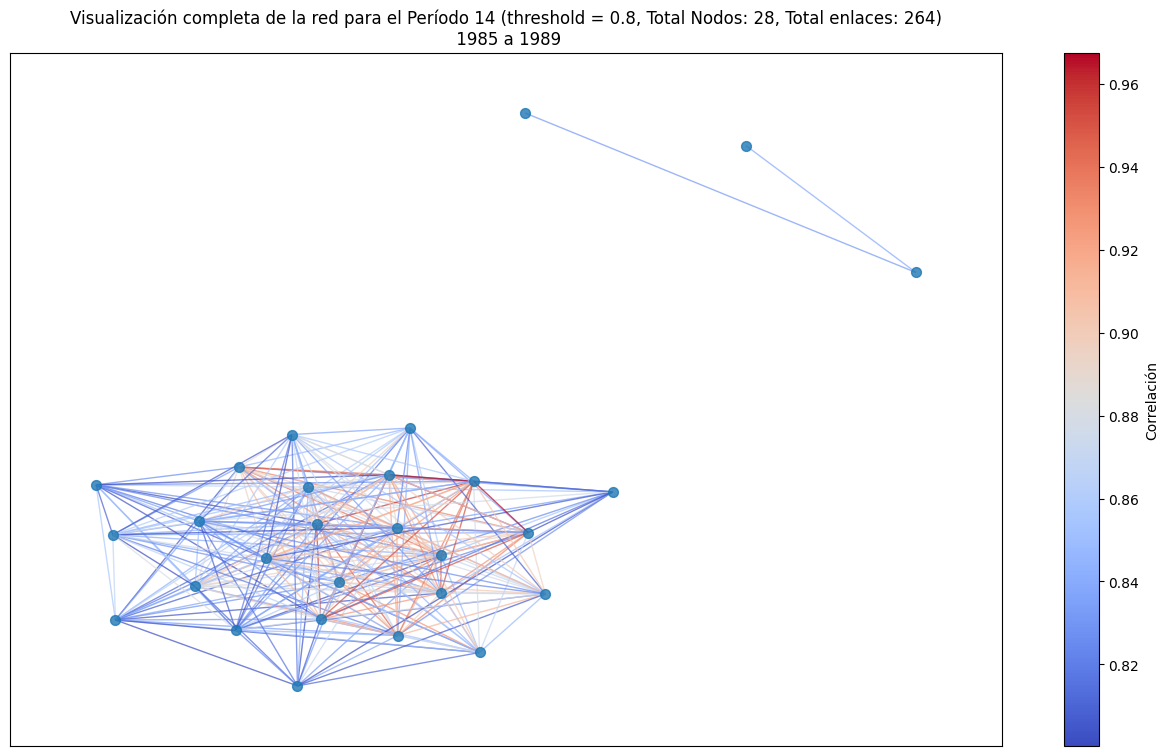

In [79]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm

# Create a graph from the filtered correlation matrix
def create_graph(filtered_correlation_matrix, threshold):
    graph = nx.Graph()
    for pair1 in filtered_correlation_matrix.index:
        for pair2 in filtered_correlation_matrix.columns:
            if pair1 != pair2 and filtered_correlation_matrix.loc[pair1, pair2] >= threshold:
                # Add edge with correlation as weight
                graph.add_edge(pair1, pair2, weight=filtered_correlation_matrix.loc[pair1, pair2])
    return graph

# Create the graph
graph = create_graph(filtered_correlation_matrix, threshold)

# Visualization of the network with color-coded edges based on correlation and adjustable node spacing
def visualize_full_graph_with_colors(graph, period, threshold, k_value):
    plt.figure(figsize=(16, 9))
    # Increase `k` to spread the nodes further apart
    pos = nx.spring_layout(graph, seed=42, k=k_value)
    
    # Extract weights for color mapping
    edges = graph.edges(data=True)
    weights = [edge_data['weight'] for _, _, edge_data in edges]
    
    # Normalize weights for color mapping
    norm = mcolors.Normalize(vmin=min(weights), vmax=max(weights))
    edge_colors = [cm.coolwarm(norm(weight)) for weight in weights]  # Use the color map "coolwarm"

    # Draw nodes and edges
    nx.draw_networkx_nodes(graph, pos, node_size=50, alpha=0.8)
    nx.draw_networkx_edges(graph, pos, edge_color=edge_colors, alpha=0.7)

    plt.title(f"Visualización completa de la red para el Período {period} (threshold = {threshold}, Total Nodos: {len(graph.nodes)}, Total enlaces: {len(graph.edges)})\n {desde} a {hasta}")
    plt.colorbar(cm.ScalarMappable(norm=norm, cmap='coolwarm'), label="Correlación")
    plt.show()

# Example usage with a higher k value to separate nodes further
visualize_full_graph_with_colors(graph, period, threshold, k_value=1.2)



In [80]:
graph.nodes()

NodeView(('Argentina_14', 'Brazil_14', 'Australia_14', 'Belgium_14', 'Denmark_14', 'Finland_14', 'France_14', 'Germany_14', 'Greece_14', 'Iceland_14', 'Italy_14', 'Japan_14', 'Mexico_14', 'New Zealand_14', 'Norway_14', 'Portugal_14', 'Spain_14', 'Sweden_14', 'Switzerland_14', 'Turkey_14', 'United Kingdom_14', 'United States_14', 'Austria_14', 'Ireland_14', 'Luxembourg_14', 'Netherlands_14', 'Canada_14', 'Chile_14'))

#### Distribución de grado de la red

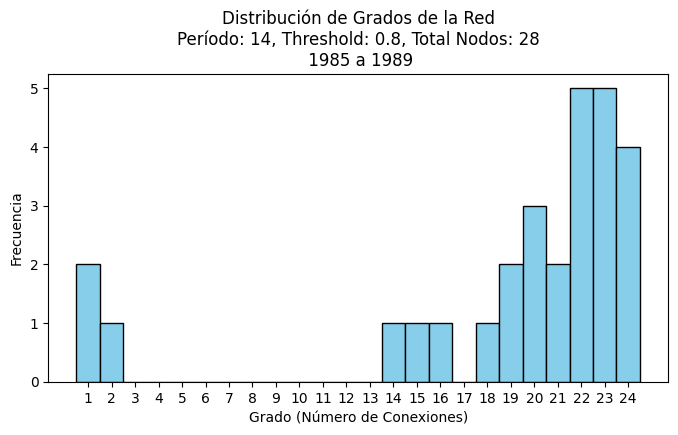

In [81]:
import matplotlib.pyplot as plt

# Función para graficar la distribución de grados
def plot_degree_distribution(graph):
    # Obtener los grados de cada nodo en el grafo
    degrees = [degree for _, degree in graph.degree()]
    
    # Crear el histograma de la distribución de grados
    plt.figure(figsize=(8, 4))
    plt.hist(degrees, bins=range(1, max(degrees) + 2), color='skyblue', edgecolor='black', align='left')
    plt.title(f"Distribución de Grados de la Red\nPeríodo: {period}, Threshold: {threshold}, Total Nodos: {len(graph.nodes())}\n {desde} a {hasta}")
    plt.xlabel("Grado (Número de Conexiones)")
    plt.ylabel("Frecuencia")
    plt.xticks(range(1, max(degrees) + 1))
    plt.show()

# Llamar a la función para graficar la distribución de grados
graph_centralidades = graph.copy()
plot_degree_distribution(graph_centralidades)


In [82]:
graph.nodes()

NodeView(('Argentina_14', 'Brazil_14', 'Australia_14', 'Belgium_14', 'Denmark_14', 'Finland_14', 'France_14', 'Germany_14', 'Greece_14', 'Iceland_14', 'Italy_14', 'Japan_14', 'Mexico_14', 'New Zealand_14', 'Norway_14', 'Portugal_14', 'Spain_14', 'Sweden_14', 'Switzerland_14', 'Turkey_14', 'United Kingdom_14', 'United States_14', 'Austria_14', 'Ireland_14', 'Luxembourg_14', 'Netherlands_14', 'Canada_14', 'Chile_14'))

#### Centralidad de la red

Aquí tienes las fórmulas en formato Markdown compatible para que se rendericen correctamente:

---

## Medidas de Centralización para Explicar la Centralidad de la Red

Existen varias medidas para cuantificar la **centralidad de una red** en su conjunto, reflejando qué tan centralizada está la red y si ciertos nodos son particularmente "importantes" o "influyentes". A continuación se presentan algunas de las medidas más comunes:

### 1. Degree Centralization (Centralización de grado)
   - **Definición**: Mide el grado en que los nodos de la red están conectados en torno a un nodo o a un pequeño conjunto de nodos. Se calcula comparando el grado de los nodos más conectados con el de todos los demás.
   - **Fórmula**: 

     $$ \text{Degree Centralization} = \frac{\sum_{i} (\text{max degree} - \text{degree}(i))}{(n-1)(n-2)} $$

     donde \( n \) es el número de nodos en la red.
   - **Interpretación**: Un valor alto de centralización de grado indica que la red tiene uno o unos pocos nodos muy conectados (similar a un "hub" en una red de aeropuertos). Un valor bajo sugiere que las conexiones están más distribuidas y no hay nodos particularmente centrales en términos de conexiones.

### 2. Betweenness Centralization (Centralización de intermediación)
   - **Definición**: Mide la centralización de la red en función de la intermediación (**betweenness**) de los nodos, es decir, qué tanto dependen los caminos entre otros nodos de los mismos nodos intermedios.
   - **Fórmula**:

     $$ \text{Betweenness Centralization} = \frac{\sum_{i} (\text{max betweenness} - \text{betweenness}(i))}{(n-1)(n-2)/2} $$

   - **Interpretación**: Una red con alta centralización de intermediación está dominada por unos pocos nodos que actúan como "puentes" o "intermediarios" entre otras partes de la red. Un valor bajo indica que no hay nodos particularmente importantes en términos de intermediación, lo cual podría indicar que la red es más distribuida.

### 3. Closeness Centralization (Centralización de cercanía)
   - **Definición**: Mide qué tan centralizada está la red en términos de cercanía (**closeness**), es decir, qué tan "cercanos" están los nodos entre sí en promedio.
   - **Fórmula**:

     $$ \text{Closeness Centralization} = \frac{\sum_{i} (\text{max closeness} - \text{closeness}(i))}{(n-1)(n-2)} $$

   - **Interpretación**: Una alta centralización de cercanía sugiere que hay uno o unos pocos nodos desde los cuales es fácil llegar a cualquier otro nodo en la red. Un valor bajo indica una red en la que todos los nodos están a distancias similares entre sí y, por lo tanto, no hay nodos significativamente más "cercanos" en términos de la red completa.

---

In [83]:
import networkx as nx

# Crear el grafo
grafo_centralidades = graph.copy()
grafo_centralidades = nx.erdos_renyi_graph(100, 0.05)  # Ejemplo de una red aleatoria

print(f"CENTRALIDADES DE LA RED/ PERIODO {period} / THRESHOLD {threshold}\n")

# Calcular Degree Centralization
degree_centrality = nx.degree_centrality(grafo_centralidades)
max_degree_centrality = max(degree_centrality.values())
degree_centralization = sum(max_degree_centrality - v for v in degree_centrality.values()) / ((len(graph) - 1) * (len(graph) - 2))
print(f"Centralización de Grado: {degree_centralization:.4f}")

# Calcular Betweenness Centralization
betweenness_centrality = nx.betweenness_centrality(grafo_centralidades, normalized=True)
max_betweenness_centrality = max(betweenness_centrality.values())
betweenness_centralization = sum(max_betweenness_centrality - v for v in betweenness_centrality.values()) / ((len(graph) - 1) * (len(graph) - 2) / 2)
print(f"Centralización de Intermediación: {betweenness_centralization:.4f}")

# Calcular Closeness Centralization
closeness_centrality = nx.closeness_centrality(grafo_centralidades)
max_closeness_centrality = max(closeness_centrality.values())
closeness_centralization = sum(max_closeness_centrality - v for v in closeness_centrality.values()) / ((len(graph) - 1) * (len(graph) - 2))
print(f"Centralización de Cercanía: {closeness_centralization:.4f}")


CENTRALIDADES DE LA RED/ PERIODO 14 / THRESHOLD 0.8

Centralización de Grado: 0.0113
Centralización de Intermediación: 0.0203
Centralización de Cercanía: 0.0100


#### DETECCIÓN DE COMUNIDADES

In [84]:
graph.nodes()

NodeView(('Argentina_14', 'Brazil_14', 'Australia_14', 'Belgium_14', 'Denmark_14', 'Finland_14', 'France_14', 'Germany_14', 'Greece_14', 'Iceland_14', 'Italy_14', 'Japan_14', 'Mexico_14', 'New Zealand_14', 'Norway_14', 'Portugal_14', 'Spain_14', 'Sweden_14', 'Switzerland_14', 'Turkey_14', 'United Kingdom_14', 'United States_14', 'Austria_14', 'Ireland_14', 'Luxembourg_14', 'Netherlands_14', 'Canada_14', 'Chile_14'))

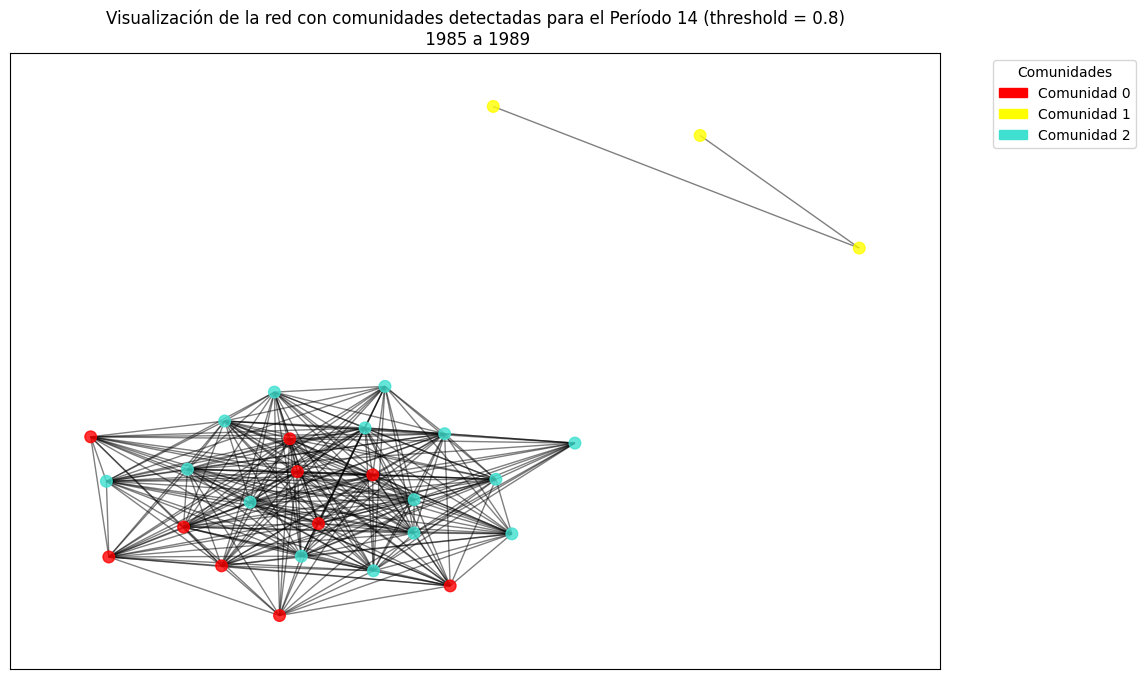

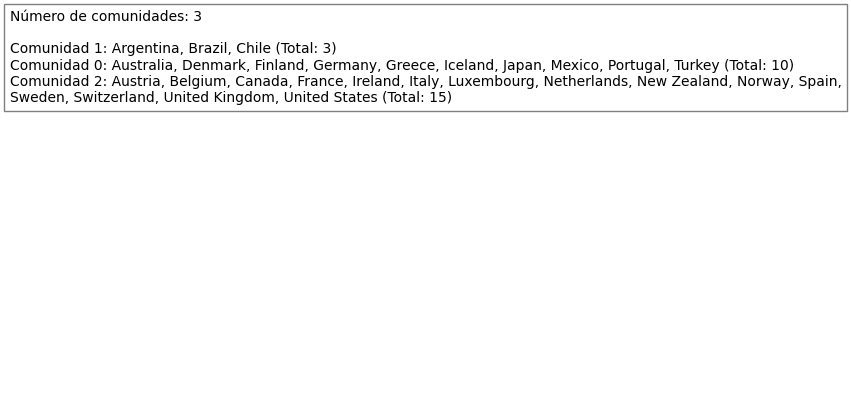

In [85]:
from community import community_louvain
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.patches as mpatches

# Crear una copia del grafo con etiquetas numéricas para usar en best_partition
def assign_partition_to_original_graph(graph):
    # Crear una copia del grafo con etiquetas numéricas
    graph_with_integers = nx.convert_node_labels_to_integers(graph, label_attribute="original_name")
    
    # Obtener la partición usando el grafo con nodos numerados
    partition = community_louvain.best_partition(graph_with_integers)
    
    # Mapear la partición a los nombres originales de los nodos
    partition_original = {data["original_name"]: community for node, community in partition.items() for data in [graph_with_integers.nodes[node]]}
    
    return partition_original

# Asignar la partición a los nombres originales del grafo
partition = assign_partition_to_original_graph(graph)

# Función para visualizar el grafo de comunidades con guía de colores
def visualize_communities_graph(graph, partition, period, threshold):
    # Lista de colores llamativos
    color_palette = ['red', 'yellow', 'turquoise', 'green', 'orange', 'purple', 'blue', 'pink']
    
    # Asignar colores a las comunidades
    unique_communities = list(set(partition.values()))
    color_map = [color_palette[partition[node] % len(color_palette)] for node in graph.nodes]

    # Dibujar el grafo
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(graph, seed=42, k=1.2)
    ax = plt.gca()
    nx.draw_networkx_nodes(graph, pos, node_color=color_map, node_size=70, alpha=0.8, ax=ax)
    nx.draw_networkx_edges(graph, pos, alpha=0.5, ax=ax)
    plt.title(f"Visualización de la red con comunidades detectadas para el Período {period} (threshold = {threshold})\n {desde} a {hasta}")

    # Crear leyenda de colores para cada comunidad
    legend_patches = [mpatches.Patch(color=color_palette[i % len(color_palette)], label=f"Comunidad {community}")
                      for i, community in enumerate(unique_communities)]
    plt.legend(handles=legend_patches, title="Comunidades", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

# Función para mostrar el cuadro de texto con la lista de comunidades y países
def display_community_details(partition):
    communities_dict = {}
    for node, community in partition.items():
        country = node.split('_')[0]
        if community not in communities_dict:
            communities_dict[community] = set()
        communities_dict[community].add(country)
    
    # Crear el texto de la lista de comunidades y sus países
    community_text = [f"Comunidad {community}: {', '.join(sorted(countries))} (Total: {len(countries)})"
                      for community, countries in communities_dict.items()]
    community_info = "\n".join(community_text)

    # Mostrar el cuadro de texto como un gráfico separado
    plt.figure(figsize=(10, 5))
    plt.text(0, 1, f"Número de comunidades: {len(communities_dict)}\n\n{community_info}", 
             fontsize=10, va='top', ha='left', wrap=True, bbox=dict(facecolor='white', alpha=0.5))
    plt.axis('off')
    plt.show()

# Visualizar el grafo de comunidades con la guía de colores
visualize_communities_graph(graph, partition, period, threshold)

# Mostrar el cuadro de texto con los países en cada comunidad
display_community_details(partition)


In [86]:
graph.nodes()

NodeView(('Argentina_14', 'Brazil_14', 'Australia_14', 'Belgium_14', 'Denmark_14', 'Finland_14', 'France_14', 'Germany_14', 'Greece_14', 'Iceland_14', 'Italy_14', 'Japan_14', 'Mexico_14', 'New Zealand_14', 'Norway_14', 'Portugal_14', 'Spain_14', 'Sweden_14', 'Switzerland_14', 'Turkey_14', 'United Kingdom_14', 'United States_14', 'Austria_14', 'Ireland_14', 'Luxembourg_14', 'Netherlands_14', 'Canada_14', 'Chile_14'))

##### NOTA: Esta celda es para analizar qué nodos (países) hacen de puente entre las comunidades cuando hay 2 comunidades solamente (caso con threshold <= 0.60 y 0.95)

In [87]:
from collections import defaultdict

# Obtener listas de nodos por comunidad
comunidad_1 = {node for node, community in partition.items() if community == 0}
comunidad_2 = {node for node, community in partition.items() if community == 1}

# Crear un diccionario para contar los enlaces de cada nodo puente
nodos_puente_enlaces = defaultdict(int)

# Encontrar los nodos puente y contar sus enlaces con la otra comunidad
for u, v in graph.edges():
    if (u in comunidad_1 and v in comunidad_2) or (u in comunidad_2 and v in comunidad_1):
        nodos_puente_enlaces[u] += 1
        nodos_puente_enlaces[v] += 1

# Ordenar los nodos puente por el número de enlaces en orden descendente
nodos_puente_ordenados = sorted(nodos_puente_enlaces.items(), key=lambda x: x[1], reverse=True)

# Mostrar los nodos puente ordenados y el número de enlaces con la otra comunidad
print("Nodos puente y sus enlaces con la otra comunidad (ordenados de mayor a menor):")
for nodo, num_enlaces in nodos_puente_ordenados:
    print(f"{nodo}: {num_enlaces} enlaces")


Nodos puente y sus enlaces con la otra comunidad (ordenados de mayor a menor):


#### Veamos qué nodos hay en cada comunidad

#### CALCULEMOS LAS MÉTRICAS DE CENTRALIDAD

In [88]:
# Calcular diferentes métricas de centralidad
def calculate_centrality(graph):
    degree_centrality = nx.degree_centrality(graph)
    betweenness_centrality = nx.betweenness_centrality(graph)
    closeness_centrality = nx.closeness_centrality(graph)

    # Convertir a dataframe para visualización
    centrality_df = pd.DataFrame({
        'Degree Centrality': degree_centrality,
        'Betweenness Centrality': betweenness_centrality,
        'Closeness Centrality': closeness_centrality
    })

    return centrality_df

# Calcular las métricas de centralidad
centrality_df = calculate_centrality(graph)

# Mostrar los 5 nodos principales para cada métrica de centralidad
def display_top_centrality(centrality_df):
    print(f"centrality_df.head()")

# Mostrar los top 5 nodos por centralidad
display_top_centrality(centrality_df)
centrality_df.head()

centrality_df.head()


,Degree Centrality,Betweenness Centrality,Closeness Centrality
Argentina_14,0.037037,0.000000,0.049383
Brazil_14,0.074074,0.002849,0.074074
Australia_14,0.703704,0.003215,0.735632
Belgium_14,0.814815,0.005005,0.820513
Denmark_14,0.851852,0.005205,0.853333


#### Analicemos las métricas de centralidad en cada nodo

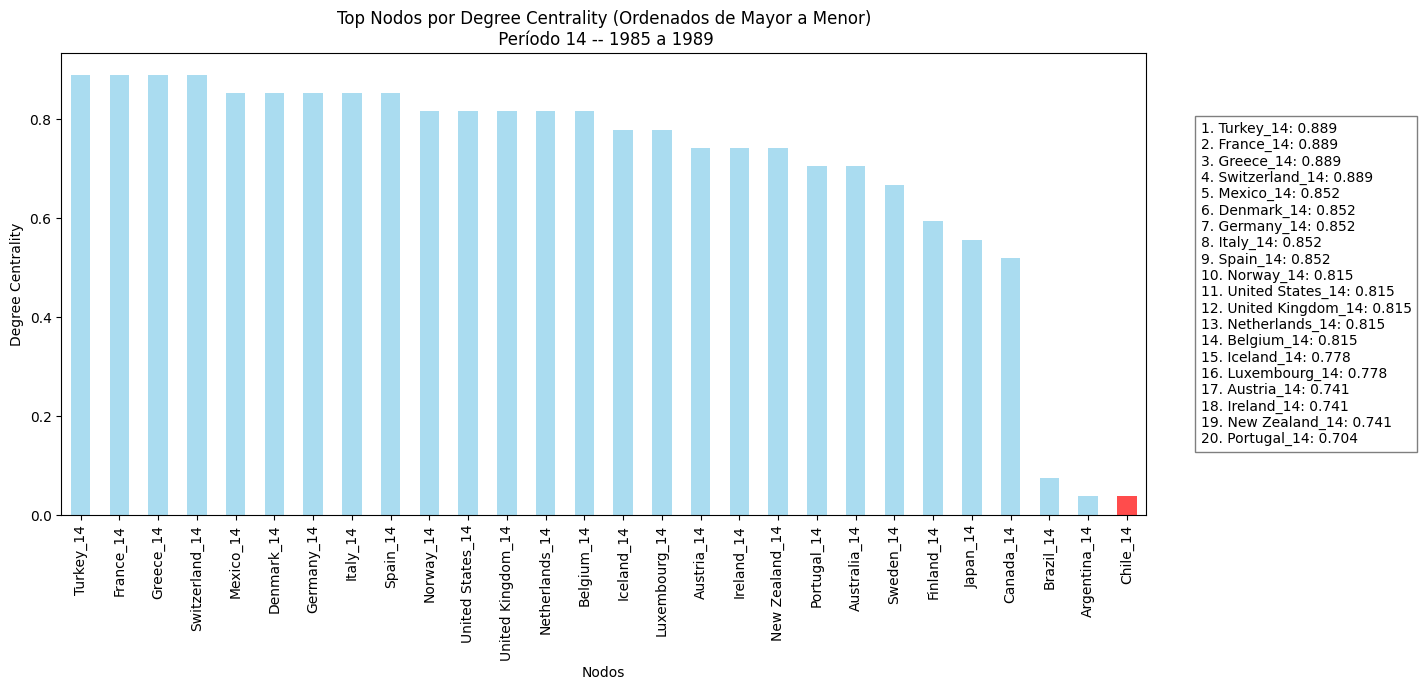

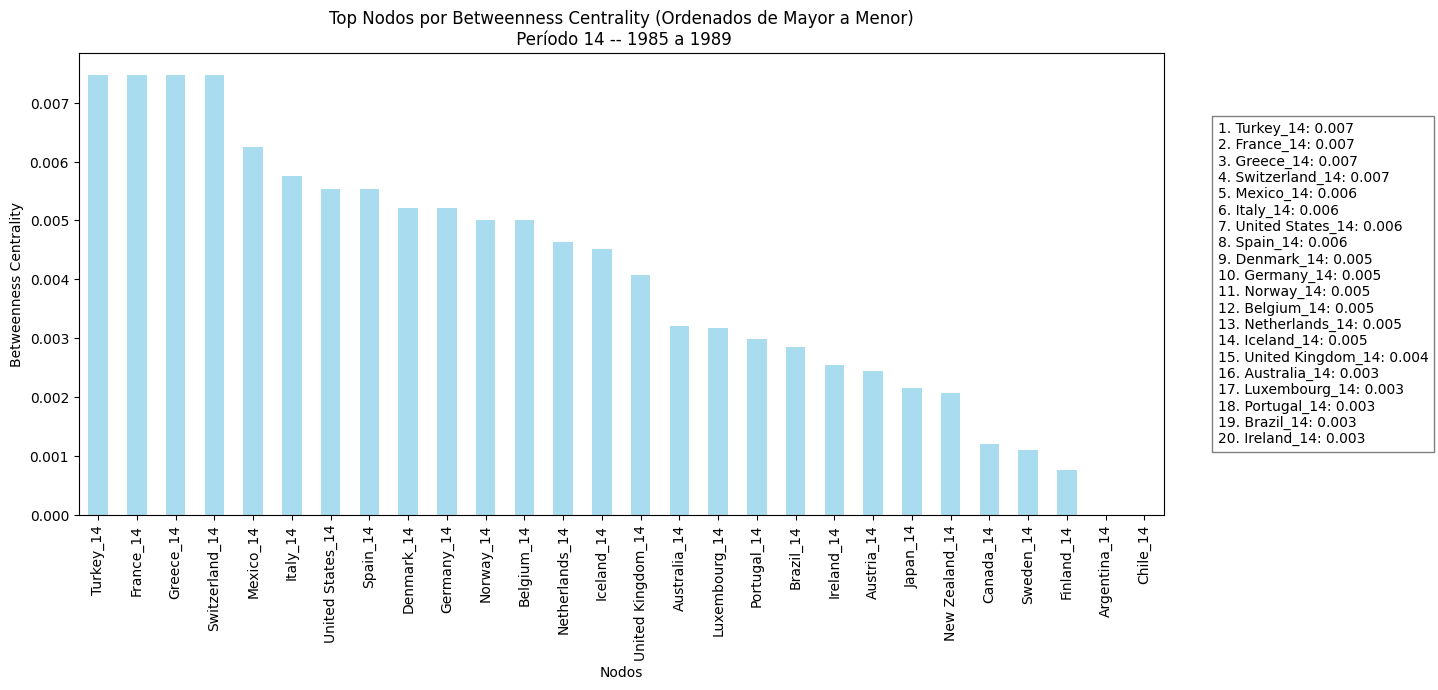

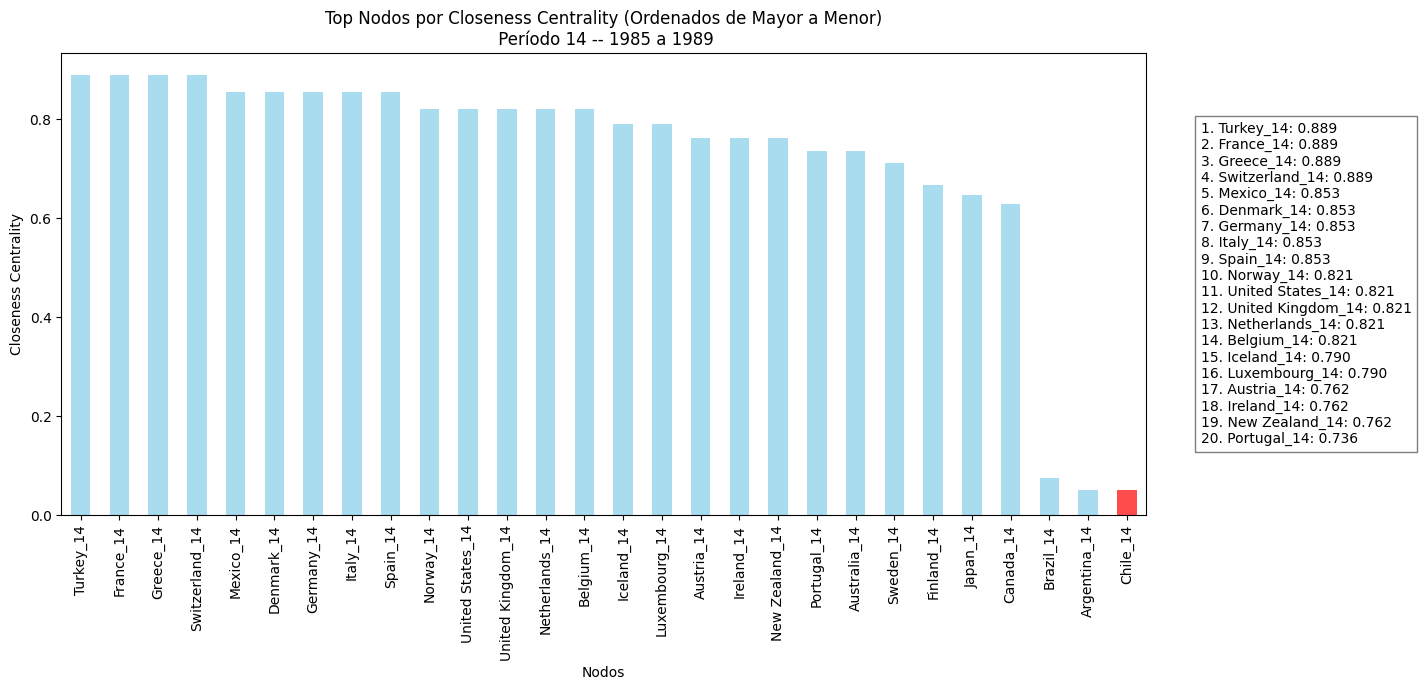

In [89]:
import matplotlib.pyplot as plt

def plot_centrality_bars_with_top_list(centrality_df, metric_name, highlight_country='Chile', top_n=20):
    # Ordenar los valores de la métrica de mayor a menor
    sorted_centrality = centrality_df[metric_name].sort_values(ascending=False)
    
    # Asignar colores: rojo para los nodos que contienen el nombre del país, azul para el resto
    colors = ['red' if highlight_country in index else 'skyblue' for index in sorted_centrality.index]
    
    # Crear un gráfico de barras para la métrica especificada
    plt.figure(figsize=(14, 6))
    ax = plt.gca()
    sorted_centrality.plot(kind='bar', color=colors, alpha=0.7, ax=ax)
    plt.title(f"Top Nodos por {metric_name} (Ordenados de Mayor a Menor)\n Período {period} -- {desde} a {hasta}")
    plt.xlabel("Nodos")
    plt.ylabel(metric_name)
    plt.xticks(rotation=90)  # Rotar etiquetas de los nodos para mejor visualización
    
    # Obtener los top 20 nodos
    top_n_df = sorted_centrality.head(top_n)
    top_list = top_n_df.index.tolist()
    values = top_n_df.tolist()
    
    # Crear la lista de texto con los top nodos
    text_list = [f"{i+1}. {node}: {value:.3f}" for i, (node, value) in enumerate(zip(top_list, values))]
    list_text = "\n".join(text_list)
    
    # Agregar la lista de top nodos a la derecha del gráfico
    ax.text(1.05, 0.5, list_text, transform=ax.transAxes, fontsize=10, va='center', bbox=dict(facecolor='white', alpha=0.5))
    
    plt.show()

# Graficar cada métrica de centralidad y mostrar la lista de top 20 nodos a la derecha
plot_centrality_bars_with_top_list(centrality_df, 'Degree Centrality', highlight_country='Chile', top_n=20)
plot_centrality_bars_with_top_list(centrality_df, 'Betweenness Centrality', highlight_country='Chile', top_n=20)
plot_centrality_bars_with_top_list(centrality_df, 'Closeness Centrality', highlight_country='Chile', top_n=20)


#### **COMENTARIOS A LA RED DE SIMILARIDAD para el período 15 (1990-1994)**

##### Concluiremos considerando tres escenarios según el nivel de correlación:
* Escenario 1: RED COMPLETA, es decir, incluye a todos los países independientemente de lo fuerte de su correlación.
* Escenario 2: RED 0.80, es decir, sólo se consideran países que tienen correlaciones >= 0.8
* Escenario 3: RED 0.60, es decir, sólo se consideran países que tienen correlaciones >= 0.6
* Nota: Chile aparece en la red a partir de un umbral de 0.75 

##### RED COMPLETA: 67 nodos países, 2.211 enlaces (el máximo posible para esta cantidad de nodos siendo una red no dirigida)
* La Centralidad de Grado: 0,0013 es baja. Esto muestra que las conexiones están distribuidas y que no hay nodos que hagan de 'nodos centrales'. Todos se relacionan con todos. Desde la perspectiva de nuestro problema, no hay países cuyo programa de gobierno se correlacione de manera significativa con muchos otros países. No hay países que hagan de 'hubs'.
* La Centralización de Intermediación: 0.0032 es baja. Reafirma lo anterior. No hay países que cumplan un rol importante en términos de 'intermediación'
* Centralización de Cercanía: 0.0018 es baja. Esto indica que todos los países están a una distancia similar entre si, y que no hay nodos más "cercanos".
* **Comunidades: 16**
* Número de países en la comunidad donde está Chile: 33

##### RED 0.8: 46 nodos países, 342 enlaces
* La Centralidad de Grado: 0,0027 es baja. Esto muestra que las conexiones están distribuidas y que no hay nodos que hagan de 'nodos centrales'. Todos se relacionan con todos. Desde la perspectiva de nuestro problema, no hay países cuyo programa de gobierno se correlacione de manera significativa con muchos otros países. No hay países que hagan de 'hubs'.
* La Centralización de Intermediación: 0.0057 es baja. Reafirma lo anterior. No hay países que cumplan un rol importante en términos de 'intermediación'
* Centralización de Cercanía: 0.0041 es baja. Esto indica que todos los países están a una distancia similar entre si, y que no hay países más "cercanos".
* **Comunidades: 5**
* Número de países en la comunidad donde está Chile: 4 (Brazil, Costa Rica, Panamá, Chile)
* La comunidad más grande la forman 24 países, de los cuales 18 son europeos.

##### RED 0.6: 53 nodos países, 1.168 enlaces
* La Centralidad de Grado: 0,0022 es baja. Esto muestra que las conexiones están distribuidas y que no hay nodos que hagan de 'nodos centrales'. Todos se relacionan con todos. Desde la perspectiva de nuestro problema, no hay países cuyo programa de gobierno se correlacione de manera significativa con muchos otros países. No hay países que hagan de 'hubs'.
* La Centralización de Intermediación: 0.0050 es baja. Reafirma lo anterior. No hay países que cumplan un rol importante en términos de 'intermediación'
* Centralización de Cercanía: 0.0031 es baja. Esto indica que todos los países están a una distancia similar entre si, y que no hay países más "cercanos".
* **Comunidades: 2**
* La Comunidad 0 es la más grande la forman 32 países, dentro de los cuales está Chile
* La Comunidad 1 está formada por 21 países (Albania, Bosnia-Herzegovina, Bulgaria, Croacia, República Checa, Estonia, Georgia, Hungría, Latvia, Lituania, México, Moldavia, Montenegro, Nor Macedonia, Polonia, Rumania, Rusia, Serbia, Slovakia, Slovenia y Ukrania)
* Los países de la Comunidad 1 comparten pertenecer en su mayoría a la Europa del Este, en su mayoría relacionados con la guerra fría y el colapso de la Unión Soviética, que en el períido en análisis (1990-1994), se concontraban en transición desde un sistema autoritario o de partido único a democracias multipartidistas con implementación compleja, con reformas institucionales y reestructuración económica; en algunos casos además con conflictos étnicos que contribuyeron a que fuera una región inestable.
* Prácticamente todos los países hacen puente con los países de la otra comunidad y no se identifica ninguno que sobresalga de todo el resto

##### Conclusión
* Desde la perspectiva de redes, considerando la correlación entre programas presidenciales entre 1990 y 1994, no se observan países con centralidad importante sea cual sea el umbral para la correlación
* Para un umbral <= 0.60, las comunidades que se crean son 2, y los países que componen una de ellas comparten una historia muy similar para el período de tiempo en en análisis (1990-1994)  
* Por lo anterior podemos decir que los datos son consistentes con ciertas realidades
---